In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, Activation
from keras.models import Model
import tensorflow
import matplotlib.pyplot as plt
from keras.models import load_model

2023-03-08 11:54:12.244730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:54:13.320764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cudnn-8.2.4.15-11.4-eluwegpwn6adr7hlku5p5wru5xzefpop/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cuda-11.4.4-ctldo35wmmwws3jbgwkgjjcjawddu3qz/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/neovim-0.7.0-terkir3wk5rst6ktv4uxyaqjditacv5p/lib
2023-03-08 11:54:13.320851: W tensorflow/compiler/xla/stream_execut

In [2]:
# make tensorlfow work better with gpus:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# eager execution:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Overview of Dataset

What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
Who collected the data? Why? When?
What evaluation criteria will you be using and why? 

https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

We are using the IMDB-Wiki dataset for multi-task learning of Age and Gender from facial image data. We will be doing multi-task by training a model to classify geneder and regress age of a certain person based on their picture.


This data was collecteted by 


In [3]:
# CONSTANTS

DATA_DIR = "/work/users/skoka/Data/wiki_crop/"
META_DATA =  "/work/users/skoka/Data/wiki_crop/wiki.mat"

PICKLES_PATH = "/work/users/skoka/Data/wiki_crop_pickles/"
GET_IMAGES_FROM_PICKLE = True

In [4]:
# extract data from a .mat file
import scipy.io as sio


mat = sio.loadmat(META_DATA)
# convert the data to a pandas dataframe
mat_data = mat['wiki'][0][0]

# 0 -> Matlab datatime format
# 1 -> Years
# 2 -> Path to image
# 3 -> Gender

# convert Matlab serial date number to datetime object
def matlab_to_datetime(matlab_serial_date):
    python_datetime = datetime.datetime.fromordinal(int(matlab_serial_date)) + \
                      datetime.timedelta(days=matlab_serial_date % 1) - \
                      datetime.timedelta(days=366)
    return python_datetime

def get_age(born_matlab_date, current_year):
    return current_year - matlab_to_datetime(born_matlab_date).year

new_data = [
    # {
        # image_path, gender, age
    # }
]

for i in range(len(mat_data[0][0])):
    new_data.append({
        "image_path": mat_data[2][0][i][0],
        "age": get_age(int(mat_data[0][0][i]), mat_data[1][0][i]),
        "gender": mat_data[3][0][i]
    })

df = pd.DataFrame(new_data)

In [5]:
# reading in images:
from PIL import Image
import os

def read_image(path):
    image = Image.open(os.path.join(DATA_DIR, path))
    image = image.resize((256, 256))
    return np.array(image)

if not GET_IMAGES_FROM_PICKLE:
    list_of_images = []
    for i in range(len(df)):
        list_of_images.append(read_image(df["image_path"][i]))
    with open(PICKLES_PATH + "list_of_images.pickle", "wb") as f:
        pickle.dump(list_of_images, f)
else:
    with open(PICKLES_PATH + "list_of_images.pickle", "rb") as f:
        list_of_images = pickle.load(f)

In [6]:
# making every image 3 channels if it isnt already
for i in range(len(list_of_images)):
    if len(list_of_images[i].shape) != 3:
        list_of_images[i] = np.stack((list_of_images[i],) * 3, axis=-1)

# adding the images to the dataframe
df["image"] = list_of_images
# drop na from the dataframe
df = df.dropna()

In [7]:
# remove images that have a mean value of 0, blank images
df = df[df["image"].apply(lambda x: x.mean()) != 0]
# get rid of images that have a mean of the most common mean, to get rid of placeholder images that are meaningless
mean = df["image"].apply(lambda x: x.mean()).value_counts().index[0]
df = df[df["image"].apply(lambda x: x.mean()) != mean]

In [8]:
# Shuffleing the Dataset becuase it is currently ordered by person's date of birth
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = np.array(df["image"])
X = np.concatenate(X)
X = X.reshape(-1, 256, 256, 3)
X = X / 255.0 # normalizing the data
Y_age = df["age"].values.astype('float32')
Y_gender = df["gender"].values.astype('float32')

## Train Test Split:

In [9]:
X_test = X[0:10000]
X_train = X[10000:]

Y_age_test = Y_age[0:10000]
Y_age_train = Y_age[10000:]

Y_gender_test = Y_gender[0:10000]
Y_gender_train = Y_gender[10000:]


# Seperate Models

## Gender Classification:

In [10]:
def resnet_block(input, output_filters, strides=1):
    input_filters = input.shape[-1]
    if input_filters != output_filters:
        new_add = tf.keras.layers.Conv2D(output_filters, (1, 1), activation='relu', strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if input_filters != output_filters:
        x = tf.keras.layers.Add()([x, new_add])
    else:
        x = tf.keras.layers.Add()([x, input])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [11]:

strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"]
)
with strategy.scope():
    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    gender_classification_model = tf.keras.Model(inputs=input, outputs=output)

    gender_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    gender_classification_model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-07 17:46:24.636333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:46:28.126851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-07 17:46:28.133361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2023-03-07 17:46:28.139920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:

history = gender_classification_model.fit(X_train,
        Y_gender_train,
        epochs=25,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
        validation_data=(X_test, Y_gender_test))
gender_classification_model.save(PICKLES_PATH + "gender_classification_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-07 17:48:34.740028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-07 17:48:37.036395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-07 17:48:39.573594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-07 17:48:42.199089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-07 17:48:46.946395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-07 17:48:51.401451: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f94b0224f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-07 17:48:51.401504: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0

658/658 [==============================] - 136s 113ms/step - loss: 1.2170 - accuracy: 0.7514 - val_loss: 0.7483 - val_accuracy: 0.8098
Epoch 2/25
658/658 [==============================] - 49s 74ms/step - loss: 0.7000 - accuracy: 0.8083 - val_loss: 0.5907 - val_accuracy: 0.8308
Epoch 3/25
658/658 [==============================] - 49s 75ms/step - loss: 0.5267 - accuracy: 0.8375 - val_loss: 0.4987 - val_accuracy: 0.8320
Epoch 4/25
658/658 [==============================] - 49s 75ms/step - loss: 0.4503 - accuracy: 0.8537 - val_loss: 0.4855 - val_accuracy: 0.8374
Epoch 5/25
658/658 [==============================] - 49s 75ms/step - loss: 0.4191 - accuracy: 0.8628 - val_loss: 0.4382 - val_accuracy: 0.8583
Epoch 6/25
658/658 [==============================] - 49s 75ms/step - loss: 0.3736 - accuracy: 0.8769 - val_loss: 0.4014 - val_accuracy: 0.8681
Epoch 7/25
658/658 [==============================] - 49s 75ms/step - loss: 0.3615 - accuracy: 0.8820 - val_loss: 0.4953 - val_accuracy: 0.8573
E

Text(0.5, 1.0, 'Loss over epochs')

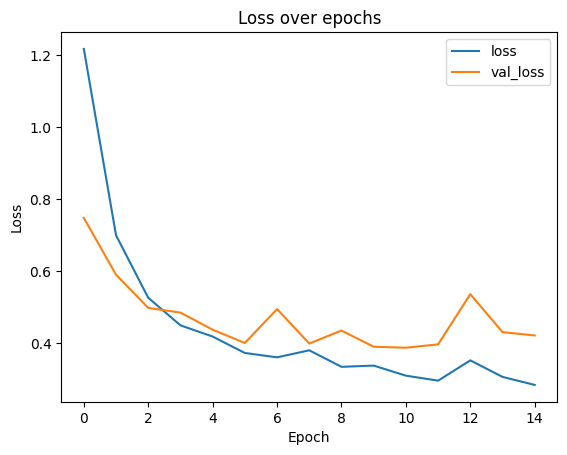

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

The validation loss converges in about 14 epochs. We define convergence as no improvment over 4 epochs.

In [13]:
gender_classification_model = load_model(PICKLES_PATH + "gender_classification_model.h5")

2023-03-08 11:08:33.714141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:08:39.743812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 11:08:39.764422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 11:08:39.776631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

## Age Regression Model:

In [11]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)
with strategy.scope():


    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='linear')(dense)

    age_regression_model = tf.keras.Model(inputs=input, outputs=output)

    age_regression_model.compile(optimizer='adam', loss='mse')

    age_regression_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-08 11:12:27.204851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:12:31.345180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 11:12:31.358334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 11:12:31.361996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:
history = age_regression_model.fit(X_train,
        Y_age_train,
        epochs=25,
        batch_size=64,
        validation_data=(X_test, Y_age_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)])
age_regression_model.save(PICKLES_PATH + "age_regression_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 11:14:05.005412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:06.102805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:07.261251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:09.077753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:10.834926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:12.170946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:13.693175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:14.819733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:14:17.015629: I tensorflow/compiler/xla/st

658/658 [==============================] - 106s 70ms/step - loss: 378.9511 - val_loss: 699.7340
Epoch 2/25
658/658 [==============================] - 34s 52ms/step - loss: 328.5402 - val_loss: 685.2299
Epoch 3/25
658/658 [==============================] - 31s 47ms/step - loss: 303.7357 - val_loss: 681.2535
Epoch 4/25
658/658 [==============================] - 33s 50ms/step - loss: 291.2619 - val_loss: 736.1733
Epoch 5/25
658/658 [==============================] - 33s 51ms/step - loss: 280.3716 - val_loss: 642.0510
Epoch 6/25
658/658 [==============================] - 30s 46ms/step - loss: 268.0216 - val_loss: 633.0607
Epoch 7/25
658/658 [==============================] - 31s 47ms/step - loss: 260.1966 - val_loss: 667.2684
Epoch 8/25
658/658 [==============================] - 29s 45ms/step - loss: 250.0140 - val_loss: 635.3804
Epoch 9/25
658/658 [==============================] - 29s 44ms/step - loss: 240.9606 - val_loss: 675.1041
Epoch 10/25
658/658 [==============================] - 3

Text(0.5, 1.0, 'Loss over epochs')

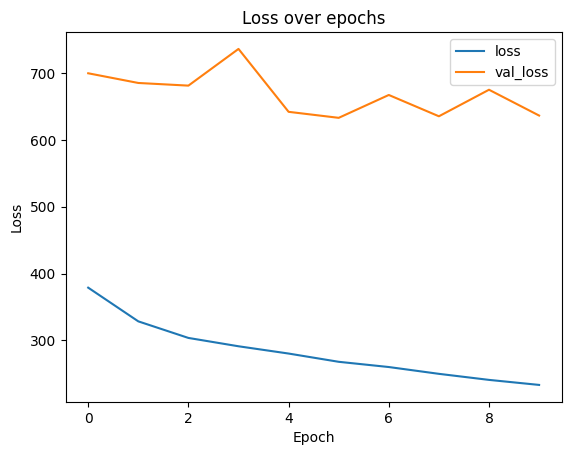

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

## Multi Task Model:

In [11]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)

with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.5)(dense)

    age_dense = tf.keras.layers.Dense(1, activation='linear')(dense)
    gender_dense = tf.keras.layers.Dense(1, activation='sigmoid', )(dense)

    multi_task_model = Model(inputs=[input], outputs=[age_dense, gender_dense])

    multi_task_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[0.002, 0.998])

    multi_task_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

2023-03-08 11:54:53.303547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:54:57.474435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 11:54:57.478315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 11:54:57.481919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                             

In [12]:
history = multi_task_model.fit(X_train,
        [Y_age_train, Y_gender_train],
        epochs=25,
        validation_data=(X_test, [Y_age_test, Y_gender_test]),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
        batch_size=64)

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 11:56:22.471900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:23.574490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:24.855763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:26.437626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:27.831049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:29.174217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:30.675983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:31.770457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 11:56:33.985978: I tensorflow/compiler/xla/st

658/658 [==============================] - 108s 71ms/step - loss: 2.0181 - dense_loss: 396.4567 - dense_1_loss: 0.8247 - val_loss: 2.1792 - val_dense_loss: 700.9996 - val_dense_1_loss: 0.4721
Epoch 2/25
658/658 [==============================] - 32s 49ms/step - loss: 1.4170 - dense_loss: 348.5198 - dense_1_loss: 0.4832 - val_loss: 2.0096 - val_dense_loss: 696.4505 - val_dense_1_loss: 0.4346
Epoch 3/25
658/658 [==============================] - 35s 53ms/step - loss: 1.2215 - dense_loss: 328.0864 - dense_1_loss: 0.4150 - val_loss: 1.8704 - val_dense_loss: 670.5710 - val_dense_1_loss: 0.4034
Epoch 4/25
658/658 [==============================] - 36s 54ms/step - loss: 1.1249 - dense_loss: 312.4282 - dense_1_loss: 0.3880 - val_loss: 1.8268 - val_dense_loss: 662.9193 - val_dense_1_loss: 0.4010
Epoch 5/25
658/658 [==============================] - 35s 53ms/step - loss: 1.0623 - dense_loss: 304.6509 - dense_1_loss: 0.3585 - val_loss: 1.8539 - val_dense_loss: 670.3657 - val_dense_1_loss: 0.4222


In [13]:
multi_task_model.save(PICKLES_PATH + "multi_task_model.h5")

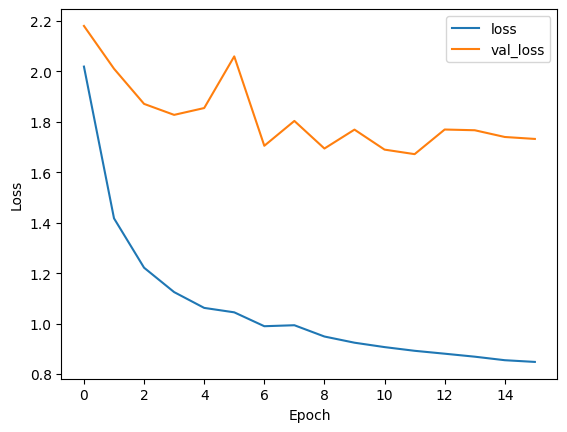

In [14]:
# plot history:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()